# Feature Engineering, Preprocessing, and Modeling

In [79]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer
import prince
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import  MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix
from sklearn.base import clone
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import RandomOverSampler
import lightgbm as lgb
import optuna
from optuna.samplers import TPESampler
import warnings
import time
import re

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
# import data
bgg = pd.read_csv('Data/browse_cmf_credits_raw.csv', index_col=0)
pd.set_option('max_colwidth', 120)

In [3]:
# checking that the data types are correct
bgg.dtypes

avg_rating       float64
geek_rating      float64
num_voters         int64
title             object
full_game_url     object
rank               int64
game_id            int64
category          object
mechanic          object
family            object
age                int64
max_play_time      int64
max_players        int64
min_play_time      int64
min_players        int64
weight           float64
dtype: object

In [4]:
# checking for null values
bgg.isnull().sum()

avg_rating          0
geek_rating         0
num_voters          0
title               0
full_game_url       0
rank                0
game_id             0
category          211
mechanic         1567
family           4614
age                 0
max_play_time       0
max_players         0
min_play_time       0
min_players         0
weight              0
dtype: int64

In [3]:
# filling nulls in categorical labels with "None"
bgg.fillna('None', inplace=True)

# confirming categorical nulls are replaced
bgg[['category','mechanic','family']].isnull().sum()

category    0
mechanic    0
family      0
dtype: int64

The family label is sparse with 2,748 different families. Using this as a feature would increase dimensionality significantly, but also many of families are unique or specific to a game or set of games, so this will not generalize well to new data. However, as we saw in EDA, Kickstarter games have a statistically higher average Geek Rating, so I do want to create a column indicating if a game was or wasn't on Kickstarter.

In [4]:
# create new column named Kickstarter and drop family column
bgg['kickstarter'] = bgg['family'].str.contains('Kickstarter')
bgg.drop(columns=['family'], inplace=True)

In [5]:
# creating dummy columns for category label - removing spaces to split correctly
bgg['category'] = bgg['category'].str.replace(' ','')
cat_dummy = bgg['category'].str.get_dummies(',').add_prefix('CATEGORY').replace({1:True,0:False})

# creating dummy columns for mechanic label
# three mechanics have commas which need to be removed before cleaning and creating dummies 
bgg['mechanic'] = bgg['mechanic'].str.replace('Deck, Bag, and Pool Building', 'Deck Bag and Pool Building')
bgg['mechanic'] = bgg['mechanic'].str.replace('I Cut, You Choose', 'I Cut You Choose')
bgg['mechanic'] = bgg['mechanic'].str.replace('Worker Placement, Different Worker Types', 'Worker Placement Different Worker Types')

bgg['mechanic'] = bgg['mechanic'].str.replace(' ','')

mech_dummy = bgg['mechanic'].str.get_dummies(',').add_prefix('MECHANIC').replace({1:True,0:False})

# concatenating with original dataframe and dropping the category and mechanic columns
bgg = pd.concat([bgg, cat_dummy, mech_dummy], axis=1)
bgg.drop(columns=['category','mechanic'], inplace=True)

# remove all other special characters
bgg = bgg.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

### Train-Test-Split, Imputing, and Scaling

The target variable will be Geek Rating, specifically if a game be in the top 1,000. Since its derived from average rating we will drop average rating. Number of voters correlates with Geek Rating, but in this context I want the model to predict the rating of a new game. Any value for number of voters for a new game would be arbitrary. Title, game url, rank, and game id are not relevant to the model and can be dropped.

In [6]:
# creating binary response column for top 1000 games
bgg['top_1000'] = bgg['rank'] <= 1000
bgg['top_1000'].replace({True:1,False:0}, inplace=True)

#### Train-Test-Split

In [7]:
# setting features, X and response variable, y
X = bgg.drop(columns=['avg_rating','geek_rating','num_voters','title','full_game_url','rank','game_id','top_1000'])
y = bgg.top_1000

# splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, shuffle=True)

#### Imputing and Scaling

In [8]:
# subsetting numerical values to be imputed
X_train_transform = X_train[['age', 'max_play_time','max_players','min_play_time','min_players','weight']]
X_test_transform = X_test[['age', 'max_play_time','max_players','min_play_time','min_players','weight']]

# instantiating the imputer and scaler
knn_imputer = KNNImputer(missing_values=0)
scaler = MinMaxScaler()

# fit to training data 
knn_imputer.fit(X_train_transform)
scaler.fit(X_train_transform)

# transform training data 
X_train_transform = pd.DataFrame(scaler.transform(knn_imputer.transform(X_train_transform)),
                              columns=['age', 'max_play_time','max_players','min_play_time',
                                       'min_players','weight'])

# transform test data
X_test_transform = pd.DataFrame(scaler.transform(knn_imputer.transform(X_test_transform)),
                              columns=['age', 'max_play_time','max_players','min_play_time',
                                       'min_players','weight'])

# concatenate imputed columns back with categorical columns
X_train = pd.concat([X_train_transform, X_train.iloc[:,6:].reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test_transform, X_test.iloc[:,6:].reset_index(drop=True)], axis=1)

KNNImputer(missing_values=0)

MinMaxScaler()

### Modeling
Testing various models with gridsearch to get a baseline. First I define functions to run and plot the models and store the resultes in a dataframe. Because the data set is imbalanced, the Precision-Recall AUC will be the deciding factor.

In [9]:
# create dataframe to store the results
model_df = pd.DataFrame(columns=['y_pred','y_pred_prob','fpr','tpr','roc_threshold','roc_auc','accuracy','precision','recall','precision-recall_threshold','f1','precision-recall_auc'])

In [10]:
def run_model(model, model_name, fit=True, xtrain=X_train, ytrain=y_train, xtest=X_test, ytest=y_test, **parameters):
    """runs a model and adds metrics to model_df"""
    global model_df
    
    # instantiate and fit model - if fit == False then just calculate the metrics
    if fit == True:
        model = model(**parameters).fit(xtrain, ytrain)
    else:
        pass
    
    # metrics
    y_pred = model.predict(xtest)
    y_pred_prob = model.predict_proba(xtest)[:,1]
    fpr, tpr, roc_threshold = roc_curve(ytest, y_pred_prob)
    roc_auc = roc_auc_score(ytest, y_pred_prob)
    precision, recall, pr_threshold = precision_recall_curve(ytest, y_pred_prob)
    f1 = f1_score(ytest, y_pred)
    pr_auc = auc(recall, precision)
    accuracy = accuracy_score(ytest, y_pred) 

    # create dataframe of results
    model_results = pd.DataFrame.from_dict({model_name:{'y_pred':y_pred, 'y_pred_prob':y_pred_prob,
                                              'fpr':fpr,'tpr':tpr, 'roc_threshold':roc_threshold,
                                              'roc_auc':roc_auc, 'accuracy':accuracy,
                                              'precision':precision, 'recall':recall,
                                              'precision-recall_threshold' : pr_threshold,
                                              'f1':f1, 'precision-recall_auc':pr_auc}},
                                           orient='index')

    
    # concats results with df
    model_df = pd.concat([model_df, model_results])

    #drops previous record if model_name is duplicated
    model_df= model_df[~model_df.index.duplicated(keep='last')]
    
    return model_df[['roc_auc','precision-recall_auc']].tail(1)

In [11]:
def plot_eval_curves(model_name):
    """plot ROC and Precision/Recall Curve for a given model in model_df"""
    global model_df
    
    h_line = len(y_test[y_test==1]) / len(y_test) # horizontal line in precision/recall curve
    _ = plt.subplots(figsize=(12,6))
    
    # plot ROC curve
    _ = plt.subplot(1,2,1)
    _ = plt.plot([0,1],[0,1], 'k--')
    _ = plt.plot(model_df.loc[model_name]['fpr'], model_df.loc[model_name]['tpr'])
    _ = plt.xlabel('False Positive Rate')
    _ = plt.ylabel('True Positive Rate')
    _ = plt.title(model_name + ' ROC Curve')
    _ = plt.legend(['roc auc score: ' + str(round(model_df.loc[model_name]['roc_auc'],4))])
    
    # plot precision-recall curve
    _ = plt.subplot(1,2,2)
    _ = plt.plot([0, 1], [h_line, h_line], linestyle='--')
    _ = plt.plot(model_df.loc[model_name]['recall'], model_df.loc[model_name]['precision'])
    _ = plt.xlabel('Recall')
    _ = plt.ylabel('Precision')
    _ = plt.title(model_name + ' Precision-Recall Curve')
    _ = plt.legend(['precision/recall auc score: ' + 
                    str(round(model_df.loc[model_name]['precision-recall_auc'],4))])
    
    plt.tight_layout()

In [12]:
# defining custom precision recall auc scorer for gridsearch
def custom_auc(y_true, y_pred_prob):
    precision, recall, pr_threshold = precision_recall_curve(y_true, y_pred_prob, pos_label=1)
    pr_auc = auc(recall, precision)
    return pr_auc

pr_auc_score = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)

In [14]:
param_grid={'penalty':['l1','l2'],
           'C':[0.01,0.1,0.5,1.0],
           'class_weight':['balanced'],
            'max_iter':[100,500,1000,2500,5000],
           'random_state':[23]}

clf = GridSearchCV(LogisticRegression(),
                   param_grid=param_grid, cv=5, scoring=pr_auc_score, n_jobs=-1).fit(X_train, y_train)

parameters = clf.best_params_
print(f'Best Logistic Regression parameters: {clf.best_params_}')

Best Logistic Regression parameters: {'C': 1.0, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'random_state': 23}


,roc_auc,precision-recall_auc
Logistic Regression,0.884259,0.379357


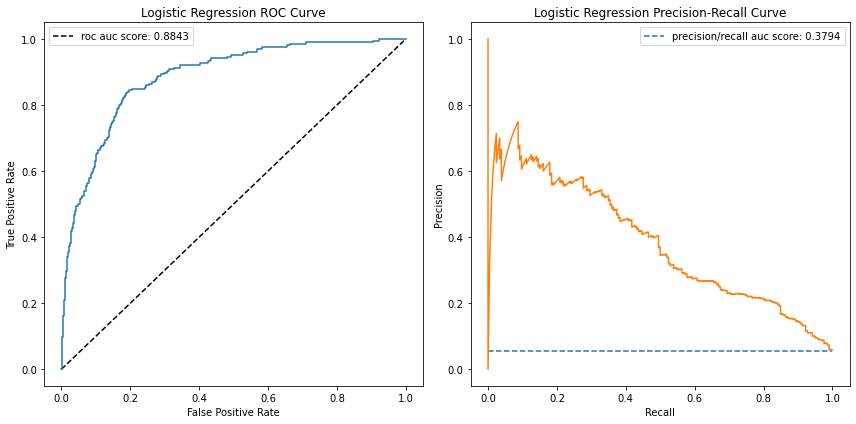

In [15]:
run_model(model=LogisticRegression, model_name='Logistic Regression', **parameters)
plot_eval_curves('Logistic Regression')

In [16]:
param_grid={'n_estimators':[50, 100, 250, 500, 1000],
           'criterion':['gini', 'entropy'],
           'max_depth':[5, 25, 50, 100, None],
           'random_state':[23]}

clf = GridSearchCV(RandomForestClassifier(),
                   param_grid=param_grid, cv=5, scoring=pr_auc_score, n_jobs=-1).fit(X_train, y_train)

parameters = clf.best_params_
print(f'Best Random Forest parameters: {clf.best_params_}')

Best Random Forest parameters: {'criterion': 'entropy', 'max_depth': 25, 'n_estimators': 1000, 'random_state': 23}


,roc_auc,precision-recall_auc
Random Forest,0.921491,0.508385


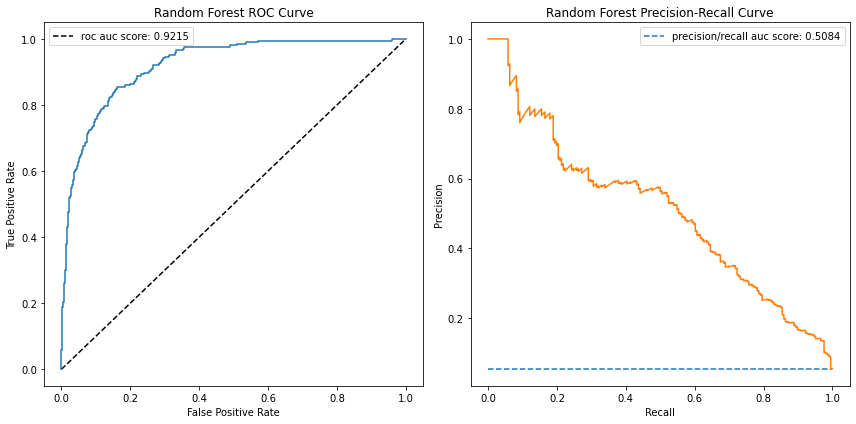

In [17]:
run_model(model=RandomForestClassifier, model_name='Random Forest', **parameters)
plot_eval_curves("Random Forest")

In [18]:
param_grid={'learning_rate':[1, 0.5, 0.25, 0.1, 0.05, 0.01],
           'n_estimators':[5, 50, 100, 250, 500],
            'max_depth':[3, 5, 10, 15, 20, 25],
           'random_state':[23]}

clf = GridSearchCV(GradientBoostingClassifier(),
                   param_grid=param_grid, cv=5, scoring=pr_auc_score, n_jobs=-1).fit(X_train, y_train)

parameters = clf.best_params_
print(f'Best Gradient Boosting parameters: {clf.best_params_}')

Best Gradient Boosting parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'random_state': 23}


,roc_auc,precision-recall_auc
Gradient Boost,0.904461,0.416739


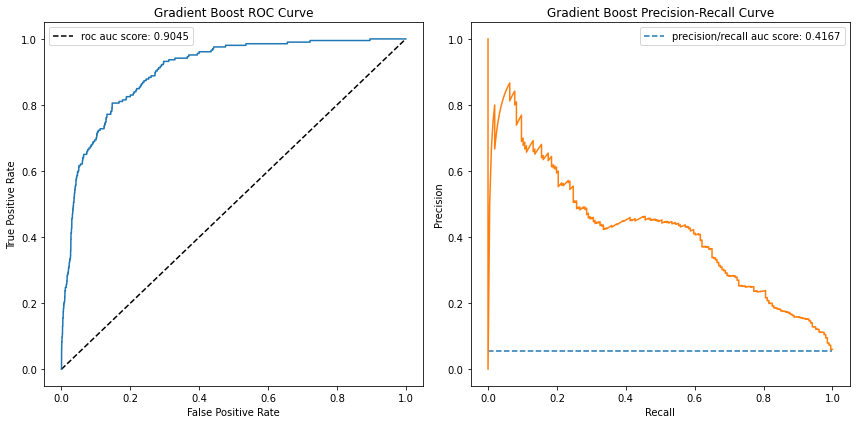

In [19]:
run_model(model=GradientBoostingClassifier, model_name='Gradient Boost', **parameters)
plot_eval_curves('Gradient Boost')

In [20]:
param_grid={'n_neighbors':[5, 25, 50, 75, 100, 125, 150, 175, 200],
           'weights':['uniform', 'distance']}

clf = GridSearchCV(KNeighborsClassifier(),
                   param_grid=param_grid, cv=5, scoring=pr_auc_score, n_jobs=-1).fit(X_train, y_train)

parameters = clf.best_params_
print(f'Best KNeighbors parameters: {clf.best_params_}')

Best KNeighbors parameters: {'n_neighbors': 100, 'weights': 'uniform'}


,roc_auc,precision-recall_auc
kNeighbors,0.839182,0.250997


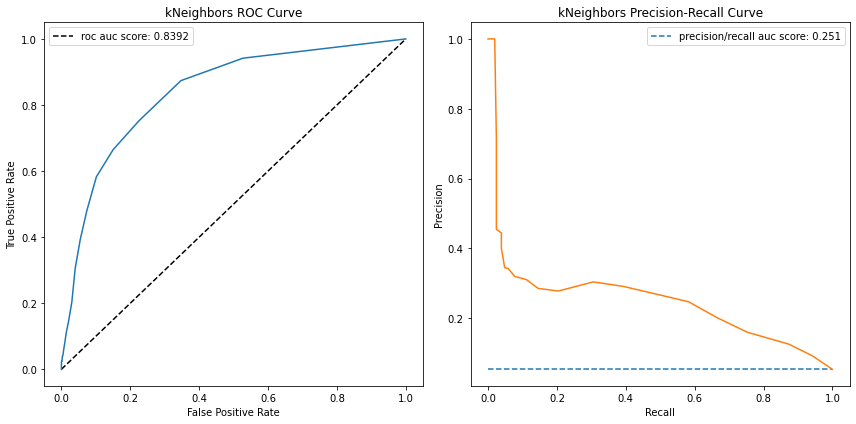

In [21]:
run_model(model=KNeighborsClassifier, model_name='kNeighbors', **parameters)
plot_eval_curves('kNeighbors')

In [23]:
param_grid={'boosting_type':['gbdt','dart','goss'],
           'num_leaves':[10, 25, 50, 100],
            'max_depth':[-1, 5, 10, 15, 20, 25],
            'learning_rate':[1, 0.5, 0.25, 0.1, 0.05, 0.01],
            'n_estimators':[5, 50, 100, 250, 500],
           'random_state':[23]}

clf = GridSearchCV(lgb.LGBMClassifier(), param_grid=param_grid, cv=5, scoring=pr_auc_score, n_jobs=-1)
clf.fit(X_train, y_train)

parameters = clf.best_params_
print(clf.best_params_)

Best LGBM parameters: {'boosting_type': 'dart', 'learning_rate': 0.1, 'max_depth': 25, 'n_estimators': 250, 'num_leaves': 50, 'random_state': 23}


,roc_auc,precision-recall_auc
LGBMClassifier,0.913805,0.456363


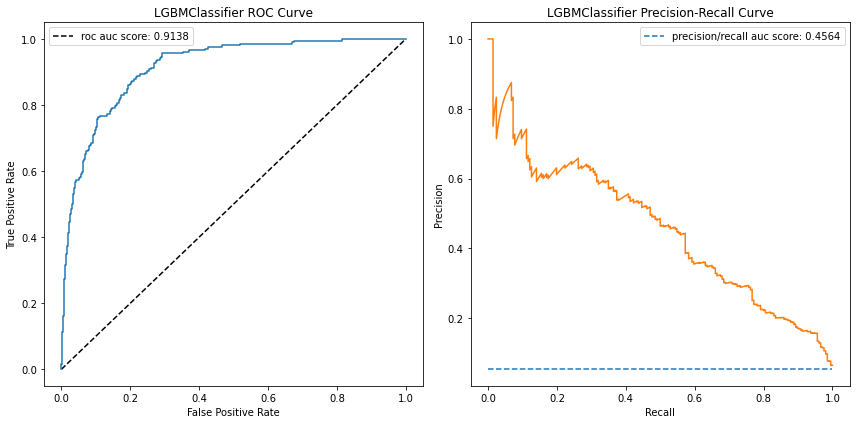

In [24]:
run_model(model=lgb.LGBMClassifier, model_name='LGBMClassifier', xtrain=X_train, **parameters)
plot_eval_curves('LGBMClassifier')

In [26]:
model_df[['roc_auc','precision-recall_auc']].tail()

,roc_auc,precision-recall_auc
Logistic Regression,0.884259,0.379357
Random Forest,0.921491,0.508385
Gradient Boost,0.904461,0.416739
kNeighbors,0.839182,0.250997
LGBMClassifier,0.913805,0.456363


Of the models tried, Random Forest did the best. Let's see what we can do to make it better.

| Classifier | Parameter Grid |
| ---- | ---- |
| Logistic Regression | <b>penalty:</b> l1, l2 <b>C:</b> 0.01, 0.1, 0.5, 1.0 <b>class_weight:</b> balanced, <b>max_iter:</b> 100, 500, 1000, 2500, 5000 |
| Random Forest | <b>n_estimators:</b> 50, 100, 250, 500, 1000 <b>criterion:</b> gini, entropy <b>max_depth:</b> 5, 25, 50, 100, None |
| Gradient Boost | <b>learning_rate:</b> 1, 0.5, 0.25, 0.1, 0.05, 0.01 <b>n_estimators:</b> 5, 50, 100, 250, 500 <b>max_depth:</b> 3, 5, 10, 15, 20, 25 |
| KNeightbors | <b>n_neighbors:</b> 5, 25, 50, 75, 100, 125, 150, 175, 200 <b>weights:</b> uniform, distance |
| LGBM | <b>boosting_type:</b> gbdt, dart, goss <b>num_leaves:</b> 10, 25, 50, 100 <b>max_depth:</b> -1, 5, 10, 15, 20, 25 <b>learning_rate:</b> 1, 0.5, 0.25, 0.1, 0.05, 0.01 <b>n_estimators:</b> 5, 50, 100, 250, 500 |

#### Multiple Correspondence Analysis (Dimensionality Reduction)
This dataset has high cardinality, it should help if we can reduce the number of features.

In [27]:
# subset categorical columns
mca_train_df = X_train.iloc[:,6:]
mca_test_df = X_test.iloc[:,6:]

# initiate and fit mca object
mca = prince.MCA(n_components=268, n_iter=3, copy=True, check_input=True, engine='auto', random_state=23)

mca.fit(mca_train_df)

#transform
mca_train_df = mca.transform(mca_train_df)
mca_test_df = mca.transform(mca_test_df)

# combine transformed data with numerical features
X_train_mca = pd.concat([X_train.iloc[:,:6], mca_train_df],axis=1)
X_test_mca = pd.concat([X_test.iloc[:,:6], mca_test_df], axis=1)

MCA(n_components=268, n_iter=3, random_state=23)

,roc_auc,precision-recall_auc
Random Forest MCA,0.882355,0.40076


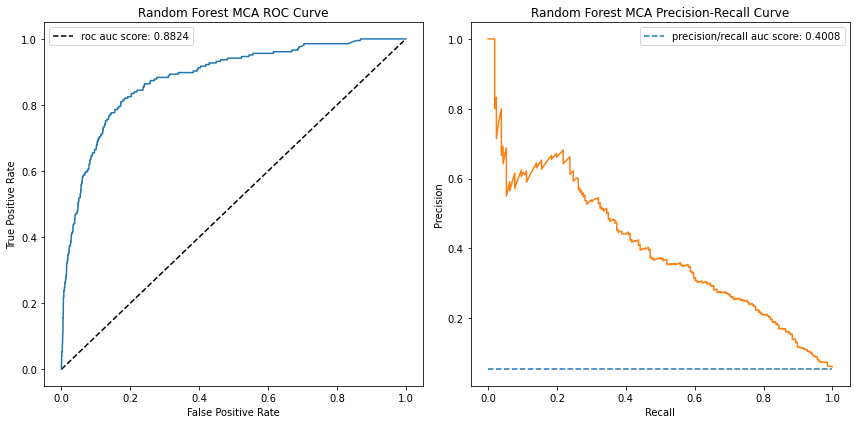

In [28]:
model = RandomForestClassifier
model_name = 'Random Forest MCA'
parameters = {'criterion': 'entropy', 'max_depth': 25, 'n_estimators': 1000, 'random_state': 23, 'n_jobs':-1}

run_model(model=model, model_name=model_name, xtrain=X_train_mca, xtest=X_test_mca, **parameters)
plot_eval_curves(model_name)

In [29]:
model_df[model_df.index.str.contains('Random Forest')][['roc_auc','precision-recall_auc']]

,roc_auc,precision-recall_auc
Random Forest,0.921491,0.508385
Random Forest MCA,0.882355,0.400760


Unfortunately this gave us worse results. Let's see what else we can do.

#### Feature Selection
Now that we've selected the random forest model to move forward with, let's see if we can reduce some of the features. I'll iterate through each column, retraining and testing the model and comparing the results to a baseline.

In [44]:
# inspiration from here: https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e
model = RandomForestClassifier(criterion='entropy', max_depth=25, n_estimators=1000, random_state=23)

def drop_col_feat_imp(model, X_train, y_train, random_state = 23):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    
    y_pred_prob = model_clone.predict_proba(X_test)
    precision, recall, pr_threshold = precision_recall_curve(y_test, y_pred_prob[:,1])
    
    benchmark_score = auc(recall, precision)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        y_pred_prob = model_clone.predict_proba(X_test.drop(col, axis = 1))
        precision, recall, pr_threshold = precision_recall_curve(y_test, y_pred_prob[:,1])
        drop_col_score = auc(recall, precision)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = pd.DataFrame(X_train.columns, importances)
    return importances_df

In [45]:
importances_df = drop_col_feat_imp(model=model, X_train=X_train, y_train=y_train)

In [47]:
importances_df.to_csv('Data/importances.csv')

In [30]:
importances_df = pd.read_csv('Data/importances.csv')

In [31]:
importances_df.reset_index(inplace=True, drop=True)
importances_df.columns =['auc_diff','feature']

In [32]:
importances_df

,auc_diff,feature
0,-0.003450,age
1,0.010052,max_play_time
2,0.006043,max_players
3,0.005354,min_play_time
4,0.004011,min_players
...,...,...
269,-0.002684,MECHANICWorkerPlacement
270,0.009228,MECHANICWorkerPlacementDifferentWorkerTypes
271,0.008313,MECHANICWorkerPlacementwithDiceWorkers
272,0.001808,MECHANICZoneofControl


array([[<AxesSubplot:title={'center':'auc_diff'}>]], dtype=object)

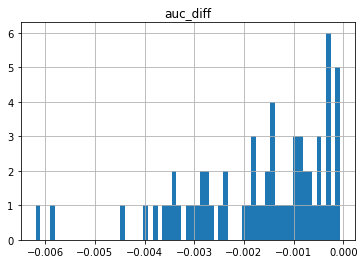

In [33]:
importances_df[importances_df.auc_diff <= 0].hist(bins=len(importances_df[importances_df.auc_diff <= 0]))

We can see there are a number of features negatively affecting the model. Let's see what happens when we drop them.

In [35]:
cols_to_drop = importances_df[importances_df.auc_diff < 0].feature.values
X_train_reduced = X_train.drop(cols_to_drop, axis=1)
X_test_reduced = X_test.drop(cols_to_drop, axis=1)
print(f'dropped columns: {cols_to_drop}')

dropped columns: ['age' 'CATEGORYAbstractStrategy' 'CATEGORYActionDexterity'
 'CATEGORYAmericanIndianWars' 'CATEGORYAviationFlight' 'CATEGORYDeduction'
 'CATEGORYEducational' 'CATEGORYEnvironmental'
 'CATEGORYExpansionforBasegame' 'CATEGORYFarming' 'CATEGORYGameSystem'
 'CATEGORYMurderMystery' 'CATEGORYMythology' 'CATEGORYNumber'
 'CATEGORYPartyGame' 'CATEGORYPikeandShot' 'CATEGORYRenaissance'
 'CATEGORYTrains' 'CATEGORYTrivia' 'CATEGORYVideoGameTheme'
 'CATEGORYWordGame' 'MECHANICPrisonersDilemma' 'MECHANICActing'
 'MECHANICActionEvent' 'MECHANICActionPoints' 'MECHANICActionRetrieval'
 'MECHANICAlliances' 'MECHANICAuctionDutchPriority'
 'MECHANICAuctionEnglish' 'MECHANICAuctionFixedPlacement'
 'MECHANICAuctionOnceAround' 'MECHANICAuctionSealedBid'
 'MECHANICAuctionTurnOrderUntilPass' 'MECHANICAutomaticResourceGrowth'
 'MECHANICBettingandBluffing' 'MECHANICChaining' 'MECHANICChitPullSystem'
 'MECHANICConnections' 'MECHANICContracts' 'MECHANICCrayonRailSystem'
 'MECHANICDieIconResolutio

,roc_auc,precision-recall_auc
Random Forest Reduced Features,0.921136,0.509506


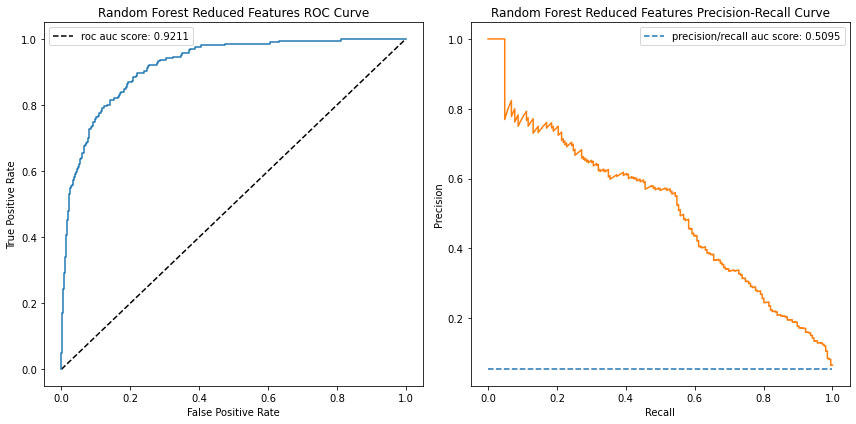

In [36]:
model = RandomForestClassifier
model_name = 'Random Forest Reduced Features'
parameters = {'criterion': 'entropy', 'max_depth': 25, 'n_estimators': 1000, 'random_state': 23}

run_model(model=model, model_name=model_name, xtrain=X_train_reduced, xtest=X_test_reduced, **parameters)
plot_eval_curves(model_name)

In [37]:
model_df[model_df.index.str.contains('Random Forest')][['roc_auc','precision-recall_auc']]

,roc_auc,precision-recall_auc
Random Forest,0.921491,0.508385
Random Forest MCA,0.882355,0.400760
Random Forest Reduced Features,0.921136,0.509506


We dropped 65 columns, but only get a marginal 0.001 increase in precision recall AUC.

#### Over Sampling

Let's now try oversampling since the data set is imbalanced.

In [196]:
rf = RandomForestClassifier(criterion='entropy', max_depth=25, n_estimators=1000, random_state= 23)
kf = KFold(n_splits=5, random_state=23, shuffle=True)
baseline = np.mean(cross_val_score(rf, X_train_reduced, y_train, cv=kf, n_jobs=-1, scoring=pr_auc_score))

sample_strats = np.arange(0.1,1.1,.1)

for sample_strat in sample_strats:
    # sampling_strategy is the percent to increases the minority class compared to the data set
    over_sample = RandomOverSampler(sampling_strategy=sample_strat, random_state=23) 
    # oversampling must be done in a pipeline so only the training data is over sampled
    pipeline = make_pipeline(over_sample,rf)
    cv = np.mean(cross_val_score(pipeline, X_train_reduced, y_train, cv=kf, n_jobs=-1, scoring=pr_auc_score))
    score = np.mean(cv)
    diff = score - baseline
    print(f'sampling strategy: {sample_strat} Precision Recall AUC Score Diff: {diff}')

sampling strategy: 0.1 Precision Recall AUC Score Diff: -0.011807160794558291
sampling strategy: 0.2 Precision Recall AUC Score Diff: -0.018982922880762032
sampling strategy: 0.30000000000000004 Precision Recall AUC Score Diff: -0.028615433169780324
sampling strategy: 0.4 Precision Recall AUC Score Diff: -0.040868821675545064
sampling strategy: 0.5 Precision Recall AUC Score Diff: -0.04843635064457463
sampling strategy: 0.6 Precision Recall AUC Score Diff: -0.05825410061936309
sampling strategy: 0.7000000000000001 Precision Recall AUC Score Diff: -0.07007735608531535
sampling strategy: 0.8 Precision Recall AUC Score Diff: -0.07848243965986978
sampling strategy: 0.9 Precision Recall AUC Score Diff: -0.08783608771489226
sampling strategy: 1.0 Precision Recall AUC Score Diff: -0.09267502566188401


At every level tested the precision recall AUC is worse than the baseline so oversampling does not improve the model.

#### Bayseian Hyperparamter Tuning

In [190]:
# define an objective function to be maximized
def rf_objective(trial):
    
    # random forest parameters
    n_estimators = trial.suggest_int('n_estimators', 50, 2000, 50)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20, 1)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    
    #min_auc = trial.suggest_discrete_uniform('min_auc', -0.007, 0, 0.001)
    #cols_to_drop = importances_df[importances_df.auc_diff < min_auc].feature.values
    
    rf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_features=max_features,
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                                bootstrap=bootstrap, random_state=23)
    
    kf = KFold(n_splits=5, random_state=23, shuffle=True)
    
    cv = cross_val_score(rf, X_train_reduced, y_train, cv=kf, n_jobs=-1, scoring=pr_auc_score)
    
    score = np.mean(cv)
    
    # if an invalid parameter combinations are tested this tells the sampler to avoid in the future
    if score == np.nan:
        raise optuna.structs.TrialPruned()
    return score

In [191]:
# create a study object and optimize the objective function
start_time = time.time()
with warnings.catch_warnings():
    # suppress warnings for invalid parameter combinations
    warnings.simplefilter("ignore")
    sampler = TPESampler(seed=23) 
    study_rf = optuna.create_study(sampler=sampler, direction='maximize')
    study_rf.optimize(rf_objective, n_trials=100)
end_time = time.time()
run_time = end_time - start_time
run_time

print(f'best parameters: {study_rf.best_params}')
print(f'best pr-auc score: {study_rf.best_value}')

[I 2020-09-28 14:16:24,556] Trial 0 finished with value: 0.3678111496370907 and parameters: {'n_estimators': 1000, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 11, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 0 with value: 0.3678111496370907.
[I 2020-09-28 14:20:31,003] Trial 1 finished with value: 0.3165366527046685 and parameters: {'n_estimators': 650, 'criterion': 'entropy', 'max_features': None, 'min_samples_split': 8, 'min_samples_leaf': 14, 'bootstrap': True}. Best is trial 0 with value: 0.3678111496370907.
[I 2020-09-28 14:20:40,763] Trial 2 finished with value: 0.4099043279772867 and parameters: {'n_estimators': 150, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 2 with value: 0.4099043279772867.
[I 2020-09-28 14:21:22,761] Trial 3 finished with value: 0.3275166205389662 and parameters: {'n_estimators': 1100, 'criterion': 'gini', 'max_features': 'log2', 'min_sampl

[I 2020-09-28 15:48:27,114] Trial 58 finished with value: 0.420023294264659 and parameters: {'n_estimators': 1050, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_split': 18, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 16 with value: 0.4234721868697804.
[I 2020-09-28 15:49:10,977] Trial 59 finished with value: 0.37359819250821735 and parameters: {'n_estimators': 1050, 'criterion': 'gini', 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 16 with value: 0.4234721868697804.
[I 2020-09-28 15:49:50,260] Trial 60 finished with value: 0.3369981188464686 and parameters: {'n_estimators': 1150, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_split': 17, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 16 with value: 0.4234721868697804.
[I 2020-09-28 15:50:43,850] Trial 61 finished with value: 0.4242951738821259 and parameters: {'n_estimators': 900, 'criterion': 'entropy', 'max_features': 'log

9575.975113391876

best parameters: {'n_estimators': 1050, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 1, 'bootstrap': True}
best pr-auc score: 0.4251939862494815


#### Hyperparameter tuning results
best parameters: {'n_estimators': 1050, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 1, 'bootstrap': True}

best pr-auc score: 0.4251939862494815

In [193]:
study_rf = study_resample.trials_dataframe()
study_rf.to_csv('Data/random_forest_tuning_results.csv')

,roc_auc,precision-recall_auc
Random Forest Reduced Features Tuned,0.920219,0.523304


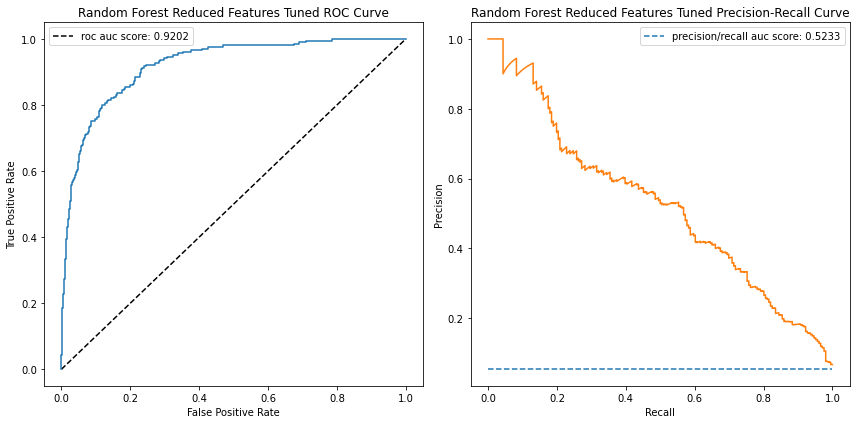

In [38]:
parameters = {'n_estimators': 1050, 'criterion': 'entropy',
              'max_features': 'log2', 'min_samples_split': 19,
              'min_samples_leaf': 1, 'bootstrap': True, 'random_state':23}

model = RandomForestClassifier
model_name = 'Random Forest Reduced Features Tuned'

run_model(model=model, model_name=model_name, xtrain=X_train_reduced, xtest=X_test_reduced, **parameters)
plot_eval_curves(model_name)

In [39]:
model_df[model_df.index.str.contains('Random Forest')][['roc_auc','precision-recall_auc']]

,roc_auc,precision-recall_auc
Random Forest,0.921491,0.508385
Random Forest MCA,0.882355,0.400760
Random Forest Reduced Features,0.921136,0.509506
Random Forest Reduced Features Tuned,0.920219,0.523304


After dropping columns and tuning the model we were able to increase the precision-recall_auc by 0.0149.

In [41]:
model_df.to_csv('Models/model_df.csv')

In [42]:
import joblib

rf = RandomForestClassifier(n_estimators=1050, criterion='entropy',
                            max_features='log2', min_samples_split=19,
                            min_samples_leaf=1, bootstrap=True, random_state=23)

joblib.dump(rf, 'Models/Random Forest Reduced Features Tuned.joblib')

['Models/Random Forest Reduced Features Tuned.joblib']

#### Thresholds

Classifier models return the probability that an observation is of a particular class. The assumption is that if the probability is greater than 0.5 than its a Top 1000 game. However, this is not set in stone and is a decision point for us to make a choice about whats more important, precision or recall. We can plot the precision and recall scores as a function of this threshold to find the appropriate thresholds for our uses.

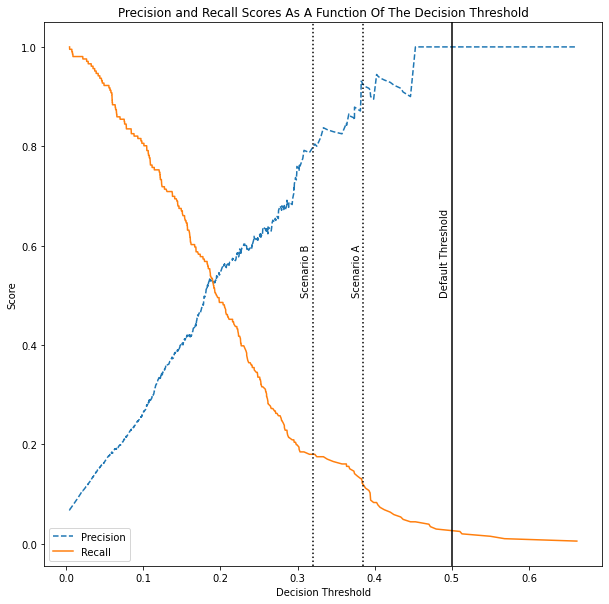

In [266]:
thresholds = model_df.loc['Random Forest Reduced Features Tuned']['precision-recall_threshold']
precisions = model_df.loc['Random Forest Reduced Features Tuned']['precision']
recalls = model_df.loc['Random Forest Reduced Features Tuned']['recall']

_ = plt.figure(figsize=(10, 10))
_ = plt.title('Precision and Recall Scores As A Function Of The Decision Threshold')
_ = plt.plot(thresholds, precisions[:-1], '--', label='Precision')
_ = plt.plot(thresholds, recalls[:-1], '-', label='Recall')
_ = plt.axvline(x=0.5, c='black')
_ = plt.annotate('Default Threshold', xy=(0.485,0.5), rotation=90)
_ = plt.axvline(x=0.385, c='k', ls=':')
_ = plt.annotate('Scenario A', xy=(0.37,0.5), rotation=90)
_ = plt.axvline(x=0.32, c='k', ls=':')
#_ = plt.hlines(.8,xmin=0,xmax=.66)
_ = plt.annotate('Scenario B', xy=(0.305,0.5), rotation=90)
_ = plt.ylabel('Score')
_ = plt.xlabel('Decision Threshold')
_ = plt.legend(loc='best')

Developing a board game is resource intensive in both time and cost, so precision is the primary metric to determine the threshold we want to use. There are two scenarios regarding the decision threshold to be considered depending on the situation of the game publisher.

<b>Scenario A:</b> This publisher is new. Perhaps they are a startup or a hobbyist trying to break into the market with a Kickstarter campaign. For this publisher a failure would be fatal, so they require high precision. At this threshold the model has trouble finding the games that fall into Top 1000, but when a top game is identified it is confident in the prediction. The threshold I recommend in this scenario is 0.385 representing a .92 precision score.

In [81]:
rf = RandomForestClassifier(n_estimators=1050, criterion= 'entropy',
              max_features='log2', min_samples_split=19,
              min_samples_leaf=1, bootstrap=True, random_state=23).fit(X_train_reduced, y_train)

In [82]:
# Adjusting the threshold from 0.50 to 0.385
y_pred_A = np.where(rf.predict_proba(X_test_reduced)[:,1] >= 0.385, 1, 0)

print('Classification Report for Scenario A')
print(classification_report(y_test, y_pred_A))

Classification Report for Scenario A
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      3598
           1       0.92      0.12      0.21       206

    accuracy                           0.95      3804
   macro avg       0.94      0.56      0.59      3804
weighted avg       0.95      0.95      0.93      3804



<b>Scenario B:</b> In this scenario the game publisher is an established business with a successful track history and has experienced game developers on staff. Due to their expertise in the industry they have more flexibility and can trade off some precision for a greater variety in the potential games they are looking to make. They might not get the best combination of features in their game, but with their vast domain knowledge they will still be able to make a successful game. The threshold for this scenario is 0.32 representing a 0.8 precision score.

In [83]:
# Adjusting the threshold from 0.50 to 0.32
y_pred_B = np.where(rf.predict_proba(X_test_reduced)[:,1] >= 0.32, 1, 0)

print('Classification Report for Scenario B')
print(classification_report(y_test, y_pred_B))

Classification Report for Scenario B
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3598
           1       0.80      0.18      0.29       206

    accuracy                           0.95      3804
   macro avg       0.88      0.59      0.63      3804
weighted avg       0.95      0.95      0.94      3804



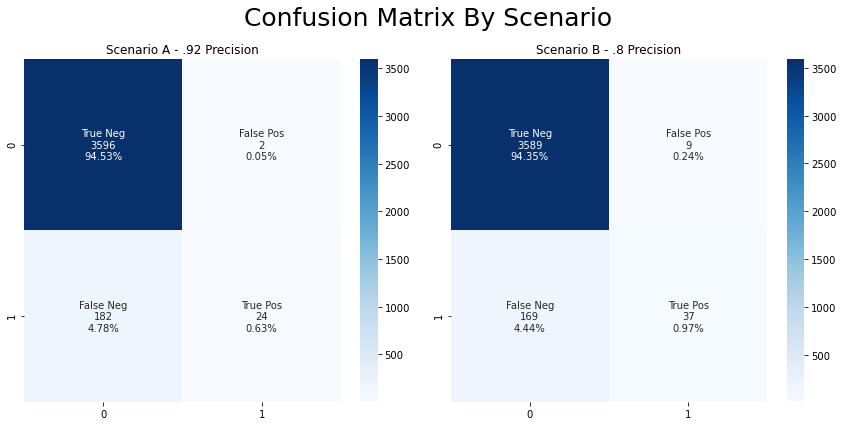

In [272]:
cmatrix_scenarioA = confusion_matrix(y_test, y_pred_A)
cmatrix_scenarioB = confusion_matrix(y_test, y_pred_B)

_ = plt.subplots(figsize=(12,6))
_ = plt.subplot(1,2,1)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cmatrix_scenarioA.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cmatrix_scenarioA.flatten()/np.sum(cmatrix_scenarioA)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
_ = sns.heatmap(cmatrix_scenarioA, annot=labels, cmap='Blues', fmt='')
_ = plt.title('Scenario A - .92 Precision')

_ = plt.subplot(1,2,2)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cmatrix_scenarioB.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cmatrix_scenarioB.flatten()/np.sum(cmatrix_scenarioB)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
_ = sns.heatmap(cmatrix_scenarioB, annot=labels, cmap='Blues', fmt='')
_ = plt.title('Scenario B - .8 Precision')
_ = plt.suptitle("Confusion Matrix By Scenario", size=25)

plt.tight_layout()

# Model Exploration





The below chart shows feature important by gain for the top 20 features. 

All numerical features (except age, which was previously dropped) are highly represented here. From EDA we saw a positive correlation (0.29) in Geek Rating and weight. There was a minimal correlation from min and max playtime (0.0032 and 0.007 respectively), and slightly negative correlations from min and max players (-0.069 and -0.028 respectively).

The categories are primarily those with many games. Economic, Wargame, Fighting, Card Game, and Fantasy are all within the top 10 categories by number of games having over 1,300 games each. The only exception is City Building, however this category (and Economic) is in the top ten by Geek Rating and has 473 games with this category.

We see a similar story with the mechanics. Hand Management, Dice Rolling, Set Collection, Variable Player Powers, Card Drafting, Area Majority Influence, Modular Board, and Grid Movement are in the top 20 mechanics by count with over 1,000 games each. The exception being Solo/Solitaire Game with only 420 games. However, it is one of the top mechanic by Geek Rating.

Lastly, we should examine select false positives and false negatives in order to better understand how a game is more than just the sum of its features.

In [48]:
rf = RandomForestClassifier(n_estimators=1050, criterion= 'entropy',
              max_features='log2', min_samples_split=19,
              min_samples_leaf=1, bootstrap=True, random_state=23).fit(X_train_reduced, y_train)

In [74]:
feature_imp_df = pd.DataFrame(data=[rf.feature_importances_])
feature_imp_df.columns = X_train_reduced.columns
feature_imp_df = feature_imp_df.T.reset_index()
feature_imp_df.columns = ['feature','importance']
feature_imp_df.head()

,feature,importance
0,max_play_time,0.050646
1,max_players,0.032665
2,min_play_time,0.044199
3,min_players,0.016358
4,weight,0.100709


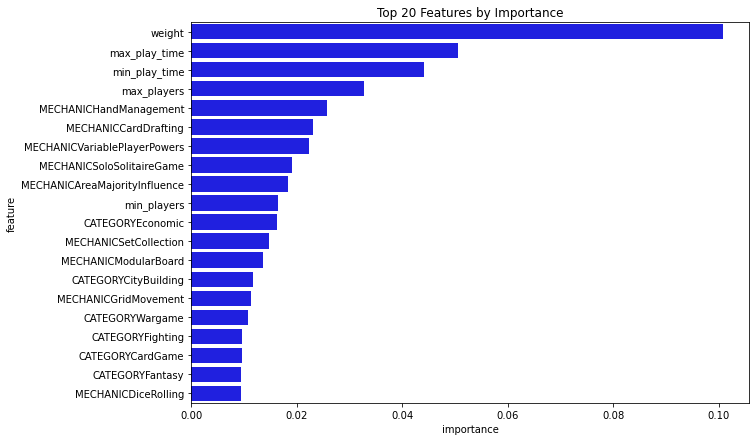

In [91]:
_ = plt.figure(figsize=(10, 7))
data = feature_imp_df.sort_values('importance', axis=0, ascending=False)
_ = sns.barplot(x='importance', y='feature', data=data.head(20), color="b")
_ = plt.title('Top 20 Features by Importance')

In [84]:
# recreating train test splits keeping individual game data (title, url, etc.)
bgg_pred = pd.read_csv('Data/browse_cmf_credits_raw.csv', index_col=0)
bgg_pred.fillna('None', inplace=True)
bgg_pred['kickstarter'] = bgg_pred['family'].str.contains('Kickstarter')
bgg_pred.drop(columns=['family'], inplace=True)
bgg_pred['top_1000'] = bgg_pred['rank'] <= 1000
bgg_pred['top_1000'].replace({True:1,False:0}, inplace=True)


X2 = bgg_pred.drop(columns=['top_1000'])
y = bgg_pred.top_1000

X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=23, shuffle=True)

# creating y_pred, actuals and y_pred_proba dataframes
#predicted = model_df.loc['Random Forest Reduced Features Tuned']['y_pred']
predicted = y_pred_B
predicted = pd.DataFrame(predicted, columns=['predicted'])
actual = pd.DataFrame(y_test, columns=['top_1000'])
probability = model_df.loc['Random Forest Reduced Features Tuned']['y_pred_prob']
probability = pd.DataFrame(probability, columns=['probability'])

# combining dataframes and creating a column indicating false positives and false negatives
pred_df = pd.concat([X2_test.reset_index(drop=True), predicted.reset_index(drop=True), actual.reset_index(drop=True), probability.reset_index(drop=True)], axis=1)
pred_df['class'] = pred_df['predicted'] - pred_df['top_1000']
pred_df['class'].replace({1:'False Positive',0:'Correct',-1:'False Negative'}, inplace=True)

# false positive and false negative dataframes
false_pos = pred_df[pred_df['class'] == 'False Positive']
false_neg = pred_df[pred_df['class'] == 'False Negative']

#### False positive games with the highest predicted probability

In [89]:
false_pos.drop(columns=['game_id']).sort_values(by=['probability'], ascending=False).head()

,avg_rating,geek_rating,num_voters,title,full_game_url,rank,category,mechanic,age,max_play_time,max_players,min_play_time,min_players,weight,kickstarter,predicted,top_1000,probability,class
1483,7.79,6.341,908,Last Bastion,https://boardgamegeek.com/boardgame/285984/last-bastion/credits,1278,"'Fantasy', 'Fighting', 'Medieval'","'Cooperative Game', 'Dice Rolling', 'Die Icon Resolution', 'Grid Movement', 'Modular Board', 'Move Through Deck', 'P...",14,45,4,45,1,2.541,False,1,0,0.446429,False Positive
117,7.96,6.462,951,Yellow & Yangtze,https://boardgamegeek.com/boardgame/244114/yellow-yangtze/credits,1046,"'Ancient', 'Civilization', 'Territory Building'","'Area Majority / Influence', 'Hand Management', 'Hexagon Grid', 'Hidden Victory Points', 'Highest-Lowest Scoring', '...",14,90,4,90,2,3.105,False,1,0,0.398675,False Positive
1600,7.89,6.382,899,Renegade,https://boardgamegeek.com/boardgame/170604/renegade/credits,1190,'Science Fiction',"'Action Points', 'Area Majority / Influence', 'Cooperative Game', 'Deck, Bag, and Pool Building', 'Dice Rolling', 'H...",14,90,5,90,1,3.650,True,1,0,0.382254,False Positive
348,7.20,6.031,672,Round House,https://boardgamegeek.com/boardgame/205498/round-house/credits,2197,"'Economic', 'Medieval'","'Card Drafting', 'Rondel', 'Set Collection', 'Worker Placement'",10,90,5,60,2,3.238,False,1,0,0.381527,False Positive
3580,6.49,5.936,1138,Uchronia,https://boardgamegeek.com/boardgame/128063/uchronia/credits,2628,"'Ancient', 'Card Game', 'City Building', 'Prehistoric'","'Card Drafting', 'Follow', 'Hand Management', 'Set Collection', 'Take That', 'Variable Phase Order'",14,60,5,45,2,2.732,False,1,0,0.373826,False Positive


First let's examine the false positives. (Note that I'm using the threshold from scenario B to examine misclassifications since the default threshold had perfect precision).


The false positive [Uchronia](https://boardgamegeek.com/boardgame/128063/uchronia) (Rank 2628) is a great example. It has the right combination of mechanics, age and weight and by all accounts should be a top game. However, digging into the reviews, we can see where Uchronia fell short. User Papa Ninja summarizes these shortfalls in his review giving the game a 4/10:

"I have been wanting to play this one for a while since I really like Glory to Rome*. Personally I found this to be a far cry from GtR; in my opinion all of the tension and interesting card synergies are missing. The locations are all very lackluster and are just worth 1, 2 or 3 points with very generic powers. The worst part of the game is how poorly the theme is tied into the game. Dinosaurs, awesome... except none of the theme comes through with any of the cards. This game was a major disappointment and not something I would seek out to play again." 

**Uchronia's gameplay is a based on the game mechanics of [Glory to Rome](https://boardgamegeek.com/boardgame/19857/glory-rome) (Rank 184)*

Another great example is Renegade (rank 1190). While still a well rated game, we can see what is holding it back from the top 1000 by looking at the negative reviews. 

User bmarting gave Renegade a 4/10 saying "All the rules grit of Mage Knight (rank 24) with none of the payoff. It has really good ideas but they're brought down by some overly convoluted systems and poor conveyance."

We also have user decoseer who wrote a 658 word review giving the game a 4/10 and concludes by saying "I'm glad the designer has found success in this product, and that people seem to genuinely like it. But I'm at a loss to understand why. I really tried to enjoy this game, but the more I prodded at the mechanics, the more unbalanced they seemed. For such a technical theme, its strange that this game is so technically flawed."

Renegade has a high weight at 3.650, but what we can see from these reviews is that the publisher leaned too far into complexity.

#### False negatives games with the lowest predicted probability

In [92]:
false_neg.drop(columns=['game_id']).sort_values(by=['probability'], ascending=True).head()

,avg_rating,geek_rating,num_voters,title,full_game_url,rank,category,mechanic,age,max_play_time,max_players,min_play_time,min_players,weight,kickstarter,predicted,top_1000,probability,class
2545,7.64,7.109,4587,KLASK,https://boardgamegeek.com/boardgame/165722/klask/credits,289,"'Action / Dexterity', 'Real-time'",None,8,10,2,10,2,1.0550,False,0,1,0.004484,False Negative
3064,6.85,6.695,12078,Can't Stop,https://boardgamegeek.com/boardgame/41/cant-stop/credits,700,'Dice',"'Dice Rolling', 'Push Your Luck'",9,30,4,30,2,1.1570,False,0,1,0.007384,False Negative
262,7.04,6.771,7754,Cribbage,https://boardgamegeek.com/boardgame/2398/cribbage/credits,616,'Card Game','Hand Management',10,30,4,30,2,1.9070,False,0,1,0.008164,False Negative
2689,7.34,6.746,3210,Skull King,https://boardgamegeek.com/boardgame/150145/skull-king/credits,640,"'Card Game', 'Nautical', 'Pirates'","'Predictive Bid', 'Trick-taking'",8,30,6,30,2,1.7705,False,0,1,0.008771,False Negative
675,7.40,7.170,11801,Agricola: All Creatures Big and Small,https://boardgamegeek.com/boardgame/119890/agricola-all-creatures-big-and-small/credits,245,"'Animals', 'Farming'","'Automatic Resource Growth', 'Enclosure', 'Tile Placement', 'Worker Placement'",13,30,2,30,2,2.3440,False,0,1,0.021562,False Negative


To wrap up, we can move on to the other end of the spectrum by taking a deeper look at the games that the model gave the lowest probability of being a top 1000 game, but actually are.

What we can see here are games that are exceptions where game design trumps expectations. They generally have low weight, and have unpopular categories or mechanics such as action/dexterity, children's game, party game, roll spin and move, and memory.

For example, [KLASK](https://boardgamegeek.com/boardgame/165722/klask/) (rank 289), which can be described as a small scale version of foosball or air hockey, by all accounts should be a terrible game; action/dexterity is not a highly rated category, and both age and weight don't align with the trends we saw. But, this is an exception. User cuazzel summarizes this well with their 9/10 rating: "I HATE dexterity games. This should say enough about my rating".

# Conclusion

The combination of unbalanced classes and the high cardinality with a dataset on the smaller side clearly cause difficulty in prediction. To improve predictive power we could increase the size of the positive class and target the top 2,500 games instead of only the top 1,000 with the understanding that the true positives may not be as highly rated. Additionally, careful consideration while reducing the number of category and mechanic features reduction will likely show improvement.

However, most importantly, we should remember that what makes a board game "fun" is a highly subjective matter. As we saw, Monopoly is one of the worst rated games, but also a household name and by and large a commercial success. We also see categories and mechanics representing games at both ends of the ranks. Other aspects such as artwork, story, and even the quality of the game components can be just as important in a game's success. In other words, games are more than just the sum of their features.